# Machine Learning Trading Bot

## Background
- Three machine learning models were utilized to train and predict the trading data sourced from Alpaca API. 
- The target was determined to be the entry price plus 3 times the Average True Range(ATR): '1'.
- The stop was determined to be the entry price minus the Average True Range (ATR): '-1'. 
- Support Vector Machine (SVM), Decision Tree models, and Stochasstic Gradient Descent (SGD) were applied to this data.

In [1]:
# initial imports
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt 
from finta import TA

import pandas as pd 
import hvplot.pandas
from pandas.tseries.offsets import DateOffset

import alpaca_trade_api as tradeapi

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm

from imblearn.under_sampling import RandomUnderSampler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import alpaca
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
from dateutil.relativedelta import relativedelta

ticker = "ETH/USD"
time_diff = datetime.now() - relativedelta(days=200)

# Alpaca Market Data Client
data_client = CryptoHistoricalDataClient()

# Defining Bar data request parameters
request_params = CryptoBarsRequest(
    symbol_or_symbols=[ticker],
    timeframe=TimeFrame(5, alpaca.data.timeframe.TimeFrameUnit.Minute),
    start=time_diff
)

# Get the bar data from Alpaca
signals_df = data_client.get_crypto_bars(request_params).df

signals_df

open       high        low      close  \
symbol  timestamp                                                               
ETH/USD 2023-02-23 14:10:00+00:00  1659.0380  1665.6600  1659.0380  1663.3700   
        2023-02-23 14:15:00+00:00  1663.7200  1670.3600  1663.1700  1669.6000   
        2023-02-23 14:20:00+00:00  1669.7000  1670.3100  1664.5800  1665.3300   
        2023-02-23 14:25:00+00:00  1665.2900  1666.6600  1663.5400  1665.4800   
        2023-02-23 14:30:00+00:00  1665.5600  1669.1500  1662.7200  1664.1000   
...                                      ...        ...        ...        ...   
        2023-09-11 18:40:00+00:00  1561.0325  1561.0325  1560.5150  1560.5150   
        2023-09-11 18:45:00+00:00  1559.7225  1560.1500  1558.2800  1558.9000   
        2023-09-11 18:50:00+00:00  1557.5170  1557.5170  1555.6300  1556.8320   
        2023-09-11 18:55:00+00:00  1555.1850  1555.6575  1555.0045  1555.6575   
        2023-09-11 19:00:00+00:00  1555.6000  1555.6000  1553.7500  1554.4635   

                                       volume  trade_count         vwap  
symbol  timestamp                                                        
ETH/USD 2023-02-23 14:10:00+00:00  372.292090        582.0  1663.587627  
        2023-02-23 14:15:00+00:00  243.885490        396.0  1667.074189  
        2023-02-23 14:20:00+00:00  227.400010        316.0  1668.143450  
        2023-02-23 14:25:00+00:00  274.575490        329.0  1665.012380  
        2023-02-23 14:30:00+00:00  608.605620        587.0  1665.547352  
...                                       ...          ...          ...  
        2023-09-11 18:40:00+00:00    0.000000          0.0     0.000000  
        2023-09-11 18:45:00+00:00    0.026694          2.0  1559.848942  
        2023-09-11 18:50:00+00:00    0.002001          2.0  1556.200000  
        2023-09-11 18:55:00+00:00    0.000000          0.0     0.000000  
        2023-09-11 19:00:00+00:00    0.009386          2.0  1555.023893  

[57643 rows x 7 columns]

In [3]:
signals_df.reset_index(level='symbol', inplace=True)
signals_df.drop(columns=["symbol"], inplace=True)

signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2023-02-23 14:10:00+00:00,1659.0380,1665.6600,1659.0380,1663.3700,372.292090,582.0,1663.587627
2023-02-23 14:15:00+00:00,1663.7200,1670.3600,1663.1700,1669.6000,243.885490,396.0,1667.074189
2023-02-23 14:20:00+00:00,1669.7000,1670.3100,1664.5800,1665.3300,227.400010,316.0,1668.143450
2023-02-23 14:25:00+00:00,1665.2900,1666.6600,1663.5400,1665.4800,274.575490,329.0,1665.012380
2023-02-23 14:30:00+00:00,1665.5600,1669.1500,1662.7200,1664.1000,608.605620,587.0,1665.547352
...,...,...,...,...,...,...,...
2023-09-11 18:40:00+00:00,1561.0325,1561.0325,1560.5150,1560.5150,0.000000,0.0,0.000000
2023-09-11 18:45:00+00:00,1559.7225,1560.1500,1558.2800,1558.9000,0.026694,2.0,1559.848942
2023-09-11 18:50:00+00:00,1557.5170,1557.5170,1555.6300,1556.8320,0.002001,2.0,1556.200000


In [4]:
# # save copy
# signals_df.to_csv("./ETH_time_series.csv", index="timestamp")

# signals_df

### Download stock time-series data from Alpaca API into Pandas DataFrame

In [5]:
# # THE FOLLOWING IS TO REQUEST IN DATA USING THE ALPACA_API
# # API credentials
# API_KEY = 'PKD98H4EZF8YRDLUZ5I2'
# SECRET_KEY = 'b5ZbNnx35m3uaB6vRnrU7TLQlgEfDw0bKf1Y8Zsm'
# API_BASE_URL = "https://paper-api.alpaca.markets"

# # Create a connection to the API 
# api = tradeapi.REST(API_KEY, SECRET_KEY, API_BASE_URL, api_version="v2")
    
# # Set the ticket symbol and the number of shares to buy
# ticker = "SPY"

# # Make API call
# signals_df = api.get_bars(ticker, "5Min", "2022-01-01", "2023-08-30", adjustment='raw').df

# # # Save the DataFrame with the date index
# # signals_df.to_csv('SPY_time_series_df.csv')

# # create a seperate dataframe for signals
# signals_df

### Read in stock time-series data from .csv file into Pandas DataFrame

In [6]:
# # Set ticker
# ticker = "AAPL"

# # Load the DataFrame from a CSV file
# signals_df = pd.read_csv('AAPL_time_series_df.csv', index_col="timestamp")

# # Convert the first column (assuming it contains datetime-like values) to DatetimeIndex
# signals_df.index = pd.to_datetime(signals_df.index)

# # Define NYSE regular trading hours
# nyse_opening_time = pd.Timestamp("09:30:00")
# nyse_closing_time = pd.Timestamp("16:00:00")

# # Filter the DataFrame to include only data within NYSE regular trading hours
# signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# # save copy
# signals_df.to_csv("../data/SPY_time_series.csv", index="timestamp")

signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2023-02-23 14:10:00+00:00,1659.0380,1665.6600,1659.0380,1663.3700,372.292090,582.0,1663.587627
2023-02-23 14:15:00+00:00,1663.7200,1670.3600,1663.1700,1669.6000,243.885490,396.0,1667.074189
2023-02-23 14:20:00+00:00,1669.7000,1670.3100,1664.5800,1665.3300,227.400010,316.0,1668.143450
2023-02-23 14:25:00+00:00,1665.2900,1666.6600,1663.5400,1665.4800,274.575490,329.0,1665.012380
2023-02-23 14:30:00+00:00,1665.5600,1669.1500,1662.7200,1664.1000,608.605620,587.0,1665.547352
...,...,...,...,...,...,...,...
2023-09-11 18:40:00+00:00,1561.0325,1561.0325,1560.5150,1560.5150,0.000000,0.0,0.000000
2023-09-11 18:45:00+00:00,1559.7225,1560.1500,1558.2800,1558.9000,0.026694,2.0,1559.848942
2023-09-11 18:50:00+00:00,1557.5170,1557.5170,1555.6300,1556.8320,0.002001,2.0,1556.200000


<Axes: title={'center': 'ETH/USD Closing Prices'}, xlabel='Timestamp', ylabel='Closing Price'>

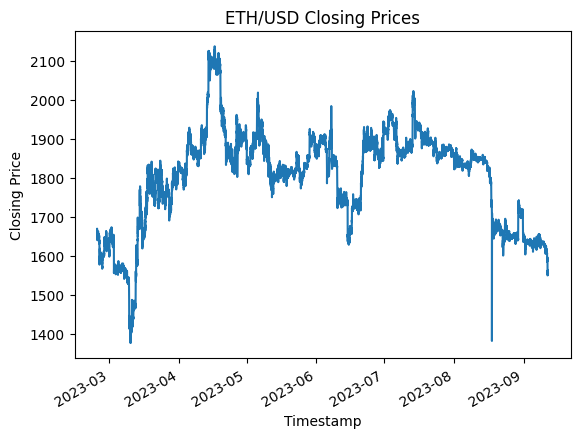

In [7]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
# plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

### Add Features (Techincal Analysis Indicators) to the DataFrame

In [8]:
# continuous features (techinal indicators) may be used
features = ["volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_LOWER", "MACD"]

#  Setup EMAs for crosses
longest_MA_window = 200
signals_df["9EMA"] = TA.EMA(signals_df, 9)
signals_df["20EMA"] = TA.EMA(signals_df, 20)
signals_df["50EMA"] = TA.EMA(signals_df, 50)
signals_df["200SMA"] = TA.SMA(signals_df, longest_MA_window)

# Setup Indicators
signals_df["ATR"] = TA.ATR(signals_df)
bbands_df = TA.BBANDS(signals_df)
macd_df = TA.MACD(signals_df)
signals_df["RSI"] = TA.RSI(signals_df)

# join macd and bbands Dataframes to signals_df
bbands_df = pd.concat([bbands_df, macd_df], axis=1)
signals_df = pd.concat([signals_df, bbands_df], axis=1)
signals_df.drop(columns=["SIGNAL", "BB_MIDDLE"], inplace=True)

# Exit is the labeled target for ML, Exit Price is for use in Pnl Metrics
signals_df["Entry Price"] = 0
signals_df["Entry Time"] = 0

signals_df["Exit Price"] = 0
signals_df["Exit Time"] = 0
signals_df["Exit"] = 0

# Review DataFrame
signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,ATR,RSI,BB_UPPER,BB_LOWER,MACD,Entry Price,Entry Time,Exit Price,Exit Time,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-23 14:10:00+00:00,1659.0380,1665.6600,1659.0380,1663.3700,372.292090,582.0,1663.587627,1663.370000,1663.370000,1663.370000,...,NaN,NaN,NaN,NaN,0.000000,0,0,0,0,0
2023-02-23 14:15:00+00:00,1663.7200,1670.3600,1663.1700,1669.6000,243.885490,396.0,1667.074189,1666.831111,1666.640750,1666.547300,...,NaN,100.000000,NaN,NaN,0.139776,0,0,0,0,0
2023-02-23 14:20:00+00:00,1669.7000,1670.3100,1664.5800,1665.3300,227.400010,316.0,1668.143450,1666.215902,1666.159450,1666.125197,...,NaN,57.533565,NaN,NaN,0.045689,0,0,0,0,0
2023-02-23 14:25:00+00:00,1665.2900,1666.6600,1663.5400,1665.4800,274.575490,329.0,1665.012380,1665.966612,1665.963304,1665.954093,...,NaN,58.205022,NaN,NaN,0.007193,0,0,0,0,0
2023-02-23 14:30:00+00:00,1665.5600,1669.1500,1662.7200,1664.1000,608.605620,587.0,1665.547352,1665.411337,1665.512586,1665.553028,...,NaN,50.321846,NaN,NaN,-0.068790,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11 18:40:00+00:00,1561.0325,1561.0325,1560.5150,1560.5150,0.000000,0.0,0.000000,1560.569372,1560.217564,1563.762697,...,1.799750,49.874703,1564.817320,1553.460830,-0.077681,0,0,0,0,0
2023-09-11 18:45:00+00:00,1559.7225,1560.1500,1558.2800,1558.9000,0.026694,2.0,1559.848942,1560.235497,1560.092082,1563.572003,...,1.775000,45.102856,1564.773763,1553.788887,-0.191636,0,0,0,0,0
2023-09-11 18:50:00+00:00,1557.5170,1557.5170,1555.6300,1556.8320,0.002001,2.0,1556.200000,1559.554798,1559.781598,1563.307689,...,1.865571,39.845706,1564.650239,1554.070611,-0.443702,0,0,0,0,0


In [9]:
# # Define NYSE regular trading hours
# nyse_opening_time = pd.Timestamp("09:30:00")
# nyse_closing_time = pd.Timestamp("16:00:00")

# # Filter the DataFrame to include only data within NYSE regular trading hours
# signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# # Review DataFrame
# signals_df

In [10]:
# Disable the warning
pd.options.mode.chained_assignment = None  # "None" suppresses the warning

### Create Volatility Based Targets and Stops

In [11]:
# here we create the exit column, our "y", for use in supervised ML
# How many rows are in the signals_df? for use in modifying DataFrame
num_rows_in_df = signals_df.shape[0]

# reward:risk ratio
reward = 1
risk = 1

# we also figure out our exit price
# hitting target price before the stop price signals a win and will be 1
# hitting stop price before hitting the target price signals a loss and will be -1
# loop thru the dataframe, from the longest_MA_window to the end (num_rows_in_df) to avoid NaN values
for j in range(longest_MA_window, num_rows_in_df):
    # entries will be on candle close
    entry = signals_df["close"].iloc[j]
    signals_df["Entry Price"].iloc[j] = entry
    signals_df["Entry Time"].iloc[j] = signals_df.index[j]
    # calculate volatility for each candle
    atr = signals_df["ATR"].iloc[j]
    # stop is entry price minus the average volatility for the entry period
    stop = entry - (risk * atr)
    # target is entry price plus the average volatility for the entry period times a multiplier
    target = entry + (reward * atr)
    # loop again thru the dataset to compare j entry price to future closing prices to see if we hit target or stop
    for k in range(j + 1, num_rows_in_df):
        # current low of the candle
        curr_low = signals_df["low"].iloc[k]
        # current high of the candle
        curr_high = signals_df["high"].iloc[k]
        # record and break if we hit stop or target, if not we check the next k period
        # if current low breaks our stop we should've sold: -1 in our "Exit" column
        if curr_low <= stop:
            signals_df["Exit Price"].iloc[j] = stop
            signals_df["Exit"].iloc[j] = -1
            # record exit time
            signals_df["Exit Time"].iloc[j] = signals_df.index[k] 
            # if we hit the stop break the inner loop to check the next row
            break
        # if current high breaks our target we should've sold: +1 in our "Exit" column
        elif curr_high >= target:
            signals_df["Exit Price"].iloc[j] = target
            signals_df["Exit"].iloc[j] = 1
            # record exit time
            signals_df["Exit Time"].iloc[j] = signals_df.index[k] 
            # if we hit the target break the inner loop to check the next row
            break

# drop beginning columns to avoid NaN values from EMA/SMA calculations
signals_df = signals_df[longest_MA_window:]

signals_df

C:\Users\range\AppData\Local\Temp\ipykernel_16948\2712784290.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1652.44' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df["Entry Price"].iloc[j] = entry
C:\Users\range\AppData\Local\Temp\ipykernel_16948\2712784290.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-02-24 06:50:00+00:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df["Entry Time"].iloc[j] = signals_df.index[j]
C:\Users\range\AppData\Local\Temp\ipykernel_16948\2712784290.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1650.3092857142858' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df["Exit Price

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,ATR,RSI,BB_UPPER,BB_LOWER,MACD,Entry Price,Entry Time,Exit Price,Exit Time,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-24 06:50:00+00:00,1651.2800,1652.8100,1650.8700,1652.4400,112.229920,172.0,1651.720436,1649.246070,1648.057604,1648.513308,...,2.130714,63.475912,1651.800327,1641.669673,0.709074,1652.4400,2023-02-24 06:50:00+00:00,1650.309286,2023-02-24 07:05:00+00:00,-1
2023-02-24 06:55:00+00:00,1652.2300,1652.9920,1650.5000,1651.7800,78.051400,135.0,1651.474501,1649.752856,1648.412118,1648.641454,...,2.187286,61.034877,1652.343266,1642.045734,0.902577,1651.7800,2023-02-24 06:55:00+00:00,1649.592714,2023-02-24 07:05:00+00:00,-1
2023-02-24 07:00:00+00:00,1651.2500,1652.5700,1650.8300,1651.5600,126.356970,158.0,1651.991332,1650.114285,1648.711916,1648.755941,...,2.110143,60.203779,1652.883812,1642.210188,1.026347,1651.5600,2023-02-24 07:00:00+00:00,1649.449857,2023-02-24 07:05:00+00:00,-1
2023-02-24 07:05:00+00:00,1650.9700,1651.5500,1649.3700,1650.7600,177.624260,231.0,1650.619894,1650.243428,1648.906972,1648.834554,...,2.146571,57.155969,1653.257934,1642.283066,1.047803,1650.7600,2023-02-24 07:05:00+00:00,1648.613429,2023-02-24 07:15:00+00:00,-1
2023-02-24 07:10:00+00:00,1650.8200,1652.7100,1650.6800,1651.3500,85.675810,117.0,1651.770115,1650.464742,1649.139641,1648.933226,...,2.207286,58.812048,1653.654332,1642.489668,1.099739,1651.3500,2023-02-24 07:10:00+00:00,1649.142714,2023-02-24 07:15:00+00:00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11 18:40:00+00:00,1561.0325,1561.0325,1560.5150,1560.5150,0.000000,0.0,0.000000,1560.569372,1560.217564,1563.762697,...,1.799750,49.874703,1564.817320,1553.460830,-0.077681,1560.5150,2023-09-11 18:40:00+00:00,1558.715250,2023-09-11 18:45:00+00:00,-1
2023-09-11 18:45:00+00:00,1559.7225,1560.1500,1558.2800,1558.9000,0.026694,2.0,1559.848942,1560.235497,1560.092082,1563.572003,...,1.775000,45.102856,1564.773763,1553.788887,-0.191636,1558.9000,2023-09-11 18:45:00+00:00,1557.125000,2023-09-11 18:50:00+00:00,-1
2023-09-11 18:50:00+00:00,1557.5170,1557.5170,1555.6300,1556.8320,0.002001,2.0,1556.200000,1559.554798,1559.781598,1563.307689,...,1.865571,39.845706,1564.650239,1554.070611,-0.443702,1556.8320,2023-09-11 18:50:00+00:00,1554.966429,2023-09-11 19:00:00+00:00,-1


### Data Cleaning

In [12]:
# include only higher than 1 volume
signals_df = signals_df.loc[signals_df["Exit Time"] != 0]

# remove all unwanted zeros from the exit column
signals_df = signals_df.loc[signals_df["Exit"] != 0]

# include only higher than 1 volume
signals_df = signals_df.loc[signals_df["volume"] != 0]

signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,ATR,RSI,BB_UPPER,BB_LOWER,MACD,Entry Price,Entry Time,Exit Price,Exit Time,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-24 06:50:00+00:00,1651.2800,1652.8100,1650.8700,1652.4400,112.229920,172.0,1651.720436,1649.246070,1648.057604,1648.513308,...,2.130714,63.475912,1651.800327,1641.669673,0.709074,1652.4400,2023-02-24 06:50:00+00:00,1650.309286,2023-02-24 07:05:00+00:00,-1
2023-02-24 06:55:00+00:00,1652.2300,1652.9920,1650.5000,1651.7800,78.051400,135.0,1651.474501,1649.752856,1648.412118,1648.641454,...,2.187286,61.034877,1652.343266,1642.045734,0.902577,1651.7800,2023-02-24 06:55:00+00:00,1649.592714,2023-02-24 07:05:00+00:00,-1
2023-02-24 07:00:00+00:00,1651.2500,1652.5700,1650.8300,1651.5600,126.356970,158.0,1651.991332,1650.114285,1648.711916,1648.755941,...,2.110143,60.203779,1652.883812,1642.210188,1.026347,1651.5600,2023-02-24 07:00:00+00:00,1649.449857,2023-02-24 07:05:00+00:00,-1
2023-02-24 07:05:00+00:00,1650.9700,1651.5500,1649.3700,1650.7600,177.624260,231.0,1650.619894,1650.243428,1648.906972,1648.834554,...,2.146571,57.155969,1653.257934,1642.283066,1.047803,1650.7600,2023-02-24 07:05:00+00:00,1648.613429,2023-02-24 07:15:00+00:00,-1
2023-02-24 07:10:00+00:00,1650.8200,1652.7100,1650.6800,1651.3500,85.675810,117.0,1651.770115,1650.464742,1649.139641,1648.933226,...,2.207286,58.812048,1653.654332,1642.489668,1.099739,1651.3500,2023-02-24 07:10:00+00:00,1649.142714,2023-02-24 07:15:00+00:00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11 18:10:00+00:00,1561.1500,1561.5150,1559.6000,1561.2500,0.102614,2.0,1560.225135,1560.412780,1559.931627,1564.638914,...,2.470393,51.824945,1564.054996,1552.984004,-0.375746,1561.2500,2023-09-11 18:10:00+00:00,1558.779607,2023-09-11 18:45:00+00:00,-1
2023-09-11 18:20:00+00:00,1560.4430,1560.8700,1558.8200,1559.8795,2.843477,2.0,1559.430266,1560.281759,1559.955001,1564.287301,...,2.486821,48.279059,1564.224230,1553.028720,-0.324032,1559.8795,2023-09-11 18:20:00+00:00,1557.392679,2023-09-11 18:50:00+00:00,-1
2023-09-11 18:25:00+00:00,1561.0320,1561.2365,1560.1555,1560.1555,0.324174,2.0,1561.070998,1560.256507,1559.974096,1564.125269,...,2.338393,49.075805,1564.207142,1553.030358,-0.292214,1560.1555,2023-09-11 18:25:00+00:00,1557.817107,2023-09-11 18:50:00+00:00,-1


<Axes: title={'center': 'ETH/USD Closing Prices'}, xlabel='Timestamp', ylabel='Closing Price'>

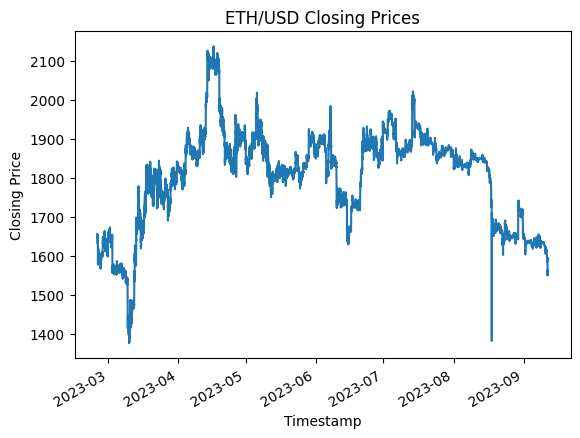

In [13]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
# plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

In [14]:
# make sure we have a sufficient training period
training_begin = str(signals_df.index.min())
training_end = str(signals_df.index.min() + DateOffset(months=3))

signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,ATR,RSI,BB_UPPER,BB_LOWER,MACD,Entry Price,Entry Time,Exit Price,Exit Time,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-24 06:50:00+00:00,1651.2800,1652.8100,1650.8700,1652.4400,112.229920,172.0,1651.720436,1649.246070,1648.057604,1648.513308,...,2.130714,63.475912,1651.800327,1641.669673,0.709074,1652.4400,2023-02-24 06:50:00+00:00,1650.309286,2023-02-24 07:05:00+00:00,-1
2023-02-24 06:55:00+00:00,1652.2300,1652.9920,1650.5000,1651.7800,78.051400,135.0,1651.474501,1649.752856,1648.412118,1648.641454,...,2.187286,61.034877,1652.343266,1642.045734,0.902577,1651.7800,2023-02-24 06:55:00+00:00,1649.592714,2023-02-24 07:05:00+00:00,-1
2023-02-24 07:00:00+00:00,1651.2500,1652.5700,1650.8300,1651.5600,126.356970,158.0,1651.991332,1650.114285,1648.711916,1648.755941,...,2.110143,60.203779,1652.883812,1642.210188,1.026347,1651.5600,2023-02-24 07:00:00+00:00,1649.449857,2023-02-24 07:05:00+00:00,-1
2023-02-24 07:05:00+00:00,1650.9700,1651.5500,1649.3700,1650.7600,177.624260,231.0,1650.619894,1650.243428,1648.906972,1648.834554,...,2.146571,57.155969,1653.257934,1642.283066,1.047803,1650.7600,2023-02-24 07:05:00+00:00,1648.613429,2023-02-24 07:15:00+00:00,-1
2023-02-24 07:10:00+00:00,1650.8200,1652.7100,1650.6800,1651.3500,85.675810,117.0,1651.770115,1650.464742,1649.139641,1648.933226,...,2.207286,58.812048,1653.654332,1642.489668,1.099739,1651.3500,2023-02-24 07:10:00+00:00,1649.142714,2023-02-24 07:15:00+00:00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-11 18:10:00+00:00,1561.1500,1561.5150,1559.6000,1561.2500,0.102614,2.0,1560.225135,1560.412780,1559.931627,1564.638914,...,2.470393,51.824945,1564.054996,1552.984004,-0.375746,1561.2500,2023-09-11 18:10:00+00:00,1558.779607,2023-09-11 18:45:00+00:00,-1
2023-09-11 18:20:00+00:00,1560.4430,1560.8700,1558.8200,1559.8795,2.843477,2.0,1559.430266,1560.281759,1559.955001,1564.287301,...,2.486821,48.279059,1564.224230,1553.028720,-0.324032,1559.8795,2023-09-11 18:20:00+00:00,1557.392679,2023-09-11 18:50:00+00:00,-1
2023-09-11 18:25:00+00:00,1561.0320,1561.2365,1560.1555,1560.1555,0.324174,2.0,1561.070998,1560.256507,1559.974096,1564.125269,...,2.338393,49.075805,1564.207142,1553.030358,-0.292214,1560.1555,2023-09-11 18:25:00+00:00,1557.817107,2023-09-11 18:50:00+00:00,-1


In [15]:
signals_df.to_csv("ETH_time_series.csv", index_label="timestamp")

### Split the data into training and testing sets.

In [16]:
# choose features
X = signals_df[features]

# 1 means a buy would've produced a profit (hit target/win), -1 means a sale would've produced a profit (his stop/loss)
y = signals_df["Exit"]
y.head()

timestamp
2023-02-24 06:50:00+00:00   -1
2023-02-24 06:55:00+00:00   -1
2023-02-24 07:00:00+00:00   -1
2023-02-24 07:05:00+00:00   -1
2023-02-24 07:10:00+00:00   -1
Name: Exit, dtype: int64

In [17]:
# Splitting into Train and Test sets
X_train = X.loc[training_begin: training_end]
y_train = y.loc[training_begin: training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [18]:
# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
# Undersample the data
rus = RandomUnderSampler(random_state=1)
undersampled_X_train_scaled, undersampled_y_train = rus.fit_resample(X_train_scaled, y_train)

### Support Vector Machine (SVC) Model

In [20]:
# Create the classifier model
model = svm.SVC(probability=True, random_state=1)
 
# Fit the model to the data using undersampled_X_train_scaled and undersampled_y_train
model = model.fit(undersampled_X_train_scaled, undersampled_y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = model.predict(undersampled_X_train_scaled)
training_probability_estimates = model.predict_proba(undersampled_X_train_scaled)

In [21]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'ETH_5MIN_10TO10_SVM.pkl')

['ETH_5MIN_10TO10_SVM.pkl']

In [22]:
# Save the X_Scaler
joblib.dump(X_scaler, "X_scaler.save") 

['X_scaler.save']

In [23]:
# Evaluate the model using a classification report
training_report = classification_report(undersampled_y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

          -1       0.55      0.61      0.58     12693
           1       0.56      0.50      0.53     12693

    accuracy                           0.56     25386
   macro avg       0.56      0.56      0.55     25386
weighted avg       0.56      0.56      0.55     25386



In [24]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)
testing_probability_estimates = model.predict_proba(X_test_scaled)

In [25]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

              precision    recall  f1-score   support

          -1       0.48      0.59      0.53      4537
           1       0.55      0.44      0.49      5198

    accuracy                           0.51      9735
   macro avg       0.52      0.52      0.51      9735
weighted avg       0.52      0.51      0.51      9735



### Visualization

In [68]:
###########CHECK THIS!!!!!!#################
# Create a predictions DataFrame for SVM
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = signals_df["close"].pct_change()

#####################

predictions_df[["Entry Price", "Entry Time", "Exit Price", "Exit Time"]] = signals_df[["Entry Price", "Entry Time", "Exit Price", "Exit Time"]]

####################

predictions_df["algo_returns"] = (signals_df["Exit Price"] - signals_df["Entry Price"])/signals_df["Entry Price"]

predictions_df["trading_algorithm_returns"] = predictions_df.pop("algo_returns") * predictions_df["predicted_signal"]

predictions_df["probability_estimates"] = testing_probability_estimates[:, 1]

predictions_df.head(20)

,predicted_signal,actual_returns,Entry Price,Entry Time,Exit Price,Exit Time,trading_algorithm_returns,probability_estimates
timestamp,,,,,,,,
2023-05-24 06:50:00+00:00,1,0.000191,1822.552154,2023-05-24 06:50:00+00:00,1820.041125,2023-05-24 07:00:00+00:00,-0.001378,0.557735
2023-05-24 06:55:00+00:00,1,0.001038,1824.443500,2023-05-24 06:55:00+00:00,1821.801658,2023-05-24 07:00:00+00:00,-0.001448,0.532238
2023-05-24 07:00:00+00:00,1,0.001069,1826.393626,2023-05-24 07:00:00+00:00,1822.429181,2023-05-24 07:25:00+00:00,-0.002171,0.537173
2023-05-24 07:05:00+00:00,1,-0.000988,1824.589815,2023-05-24 07:05:00+00:00,1820.605375,2023-05-24 07:35:00+00:00,-0.002184,0.557669
2023-05-24 07:10:00+00:00,1,0.000867,1826.172132,2023-05-24 07:10:00+00:00,1822.182596,2023-05-24 07:25:00+00:00,-0.002185,0.545023
2023-05-24 07:15:00+00:00,1,-0.001025,1824.300000,2023-05-24 07:15:00+00:00,1820.293667,2023-05-24 07:35:00+00:00,-0.002196,0.560665
2023-05-24 07:20:00+00:00,1,-0.000896,1822.665355,2023-05-24 07:20:00+00:00,1818.692176,2023-05-24 07:55:00+00:00,-0.002180,0.572173
2023-05-24 07:25:00+00:00,1,0.000474,1823.529510,2023-05-24 07:25:00+00:00,1819.539163,2023-05-24 07:50:00+00:00,-0.002188,0.569122
2023-05-24 07:30:00+00:00,1,0.000086,1823.687190,2023-05-24 07:30:00+00:00,1819.833653,2023-05-24 07:50:00+00:00,-0.002113,0.566665


In [72]:
# Initialize buy_signals_df
buy_signals_df = pd.DataFrame()
buy_signals_df = pd.concat([buy_signals_df, predictions_df.iloc[[0]]])
######################
last_trade_exit_time = predictions_df["Exit Time"].iloc[0]

for j in range(1, predictions_df.shape[0]):
    entry_time = predictions_df["Entry Time"].iloc[j]
    exit_signal = predictions_df["predicted_signal"].iloc[j]
    if entry_time <= last_trade_exit_time or exit_signal == -1:
        continue
    else:
        buy_signals_df = pd.concat([buy_signals_df, predictions_df.iloc[[j]]])
        last_trade_exit_time = predictions_df["Exit Time"].iloc[j]

        
######################

# # Filter rows where the predicted signal is 1 and the probability estimate is >= 0.50
# buy_signals_df = predictions_df["probability_estimates"] >= 0.50

buy_signals_df

,predicted_signal,actual_returns,Entry Price,Entry Time,Exit Price,Exit Time,trading_algorithm_returns,probability_estimates
timestamp,,,,,,,,
2023-05-24 06:50:00+00:00,1,0.000191,1822.552154,2023-05-24 06:50:00+00:00,1820.041125,2023-05-24 07:00:00+00:00,-0.001378,0.557735
2023-05-24 07:05:00+00:00,1,-0.000988,1824.589815,2023-05-24 07:05:00+00:00,1820.605375,2023-05-24 07:35:00+00:00,-0.002184,0.557669
2023-05-24 07:40:00+00:00,1,0.000897,1822.385090,2023-05-24 07:40:00+00:00,1818.431901,2023-05-24 07:55:00+00:00,-0.002169,0.566507
2023-05-24 08:00:00+00:00,1,0.001418,1820.517357,2023-05-24 08:00:00+00:00,1824.650204,2023-05-24 09:20:00+00:00,0.002270,0.569427
2023-05-24 09:30:00+00:00,1,-0.000506,1820.832740,2023-05-24 09:30:00+00:00,1818.783367,2023-05-24 10:25:00+00:00,-0.001126,0.507553
...,...,...,...,...,...,...,...,...
2023-09-11 15:15:00+00:00,1,0.000931,1556.764000,2023-09-11 15:15:00+00:00,1564.308286,2023-09-11 16:00:00+00:00,0.004846,0.584037
2023-09-11 16:15:00+00:00,1,-0.002276,1560.650000,2023-09-11 16:15:00+00:00,1557.154107,2023-09-11 17:00:00+00:00,-0.002240,0.558405
2023-09-11 17:05:00+00:00,1,-0.000215,1556.055000,2023-09-11 17:05:00+00:00,1553.367536,2023-09-11 17:15:00+00:00,-0.001727,0.586151


### Evaluation Metrics

In [73]:
# Calculate the time period for which you want to calculate the frequency (e.g., in days)
start_date = buy_signals_df.index.min()
end_date = buy_signals_df.index.max()
time_period_days = (end_date - start_date).days + 1  # Adding 1 to include both start and end dates

# Filter the winning, losing, and total trades
winning_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]
losing_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]
total_trades = buy_signals_df["trading_algorithm_returns"]

# Calculate gross profit (positive returns) and gross loss (negative returns)
gross_profit = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]['trading_algorithm_returns'].sum() * 100
gross_loss = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]['trading_algorithm_returns'].sum() * 100

# Calculate the average return of your trading strategy
average_return = buy_signals_df['trading_algorithm_returns'].mean()

# Calculate the risk-free rate (e.g., Treasury bill rate)
# You need to specify an appropriate risk-free rate for your analysis
risk_free_rate = 0.02  # Replace with the risk-free rate you want to use (e.g., 2% for a Treasury bill)

# Calculate downside returns (negative returns)
downside_returns = buy_signals_df['trading_algorithm_returns'][buy_signals_df['trading_algorithm_returns'] < 0]

# Calculate the downside deviation (standard deviation of negative returns)
downside_deviation = (downside_returns * 100).std()

# Calculate the Risk:Reward Ratio
risk_reward_ratio= reward/risk

# Calculate the win rate (if you haven't already)
win_rate = len(winning_trades) / len(total_trades)

# Calculate the profit factor
profit_factor = abs(gross_profit / gross_loss)

# Calculate the Sortino Ratio
sortino_ratio = (average_return - risk_free_rate) / downside_deviation

# Calculate the average profit per winning trade
average_profit_per_winning_trade = winning_trades['trading_algorithm_returns'].mean()

# Calculate the average loss per losing trade
average_loss_per_losing_trade = losing_trades['trading_algorithm_returns'].mean()

# Calculate the trade frequency (trades per day)
trade_frequency_per_day = len(total_trades) / time_period_days

# Calculate the volatility of your trading strategy's returns
algo_volatility = buy_signals_df['trading_algorithm_returns'].std()

# Calculate the cumulative returns of the algo
cumulative_returns = ( 1 + buy_signals_df['trading_algorithm_returns']).sum()

# Print the sorted metrics by importance
print("Risk:Reward Ratio:", risk_reward_ratio)
print("Win Rate (%):", win_rate * 100)
print("Profit Factor:", profit_factor)
print("Sortino Ratio:", sortino_ratio)
print("Average Profit per Winning Trade (%):", average_profit_per_winning_trade * 100)
print("Average Loss per Losing Trade (%):", average_loss_per_losing_trade * 100)
print("Average Return (%):", average_return * 100)
print("Trade Frequency (Trades per Day):", trade_frequency_per_day)
print("Downside Deviation:", downside_deviation)
print("Volatility (Standard Deviation of Algo Returns):", algo_volatility)
print("Gross Profit (%):", gross_profit)
print("Gross Loss (%):", gross_loss)
print("Total Number of Winning Trades:", len(winning_trades))
print("Total Number of Trades:", len(total_trades))
print("Risk-Free Rate (%):", risk_free_rate * 100)


Risk:Reward Ratio: 1.0
Win Rate (%): 52.67399267399268
Profit Factor: 1.2250098558854712
Sortino Ratio: -0.11461948739291752
Average Profit per Winning Trade (%): 0.2639025511189307
Average Loss per Losing Trade (%): -0.23977305571865762
Average Return (%): 0.025532996527661795
Trade Frequency (Trades per Day): 12.297297297297296
Downside Deviation: 0.1722627668630058
Volatility (Standard Deviation of Algo Returns): 0.003147733082972525
Gross Profit (%): 189.74593425451116
Gross Loss (%): -154.89339399425282
Total Number of Winning Trades: 719
Total Number of Trades: 1365
Risk-Free Rate (%): 2.0


### WIP METRICS

In [ ]:
# maximum drawdown (MDD)
# peters ratio
# t-stat
# kelly criterion
# sharpe ratio
# calmar ratio
# pain/gain ratio
# ulcer index
# k-ratio


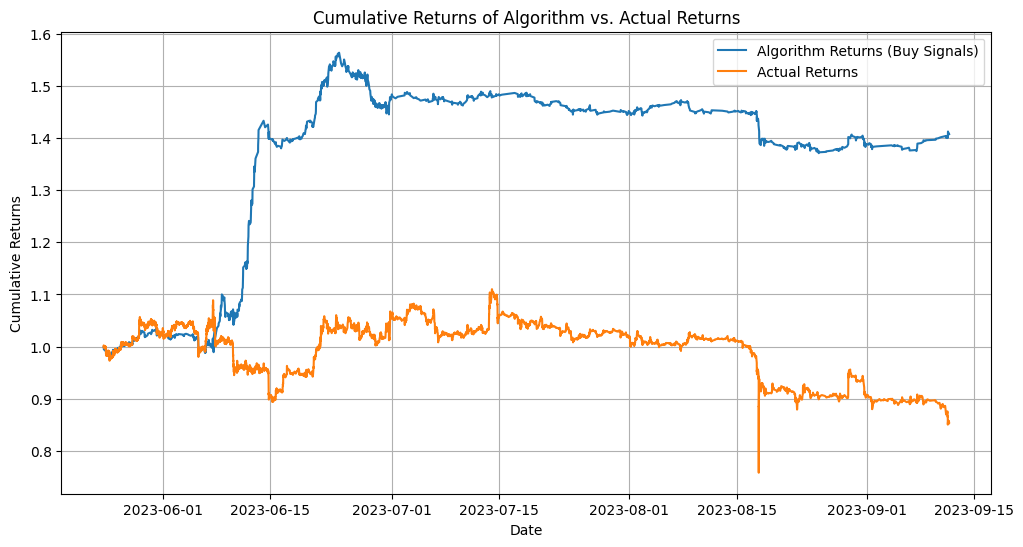

In [74]:
# Calculate cumulative returns for the algorithmic trading strategy
buy_signals_df.loc[:, "Cumulative Algo Returns"] = (1 + buy_signals_df.loc[:, "trading_algorithm_returns"]).cumprod()

# Calculate cumulative returns for the actual stock returns
predictions_df.loc[:, "Cumulative Actual Returns"] = (1 + predictions_df.loc[:, "actual_returns"]).cumprod()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(buy_signals_df.index, buy_signals_df["Cumulative Algo Returns"], label="Algorithm Returns (Buy Signals)")
plt.plot(predictions_df.index, predictions_df["Cumulative Actual Returns"], label="Actual Returns")
plt.xlabel("Date") 
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns of Algorithm vs. Actual Returns")
plt.legend()
plt.grid(True)
plt.show()

In [76]:
import pandas as pd

# Assuming your dataframe is named 'buy_signals_df'
# Step 2: Calculate cumulative returns
buy_signals_df['cumulative_returns'] = (1 + buy_signals_df['trading_algorithm_returns']).cumprod()

# Step 3: Calculate the peak
buy_signals_df['peak'] = buy_signals_df['cumulative_returns'].cummax()

# Step 4: Calculate drawdown
buy_signals_df['drawdown'] = buy_signals_df['cumulative_returns'] / buy_signals_df['peak'] - 1

# Step 5: Find the maximum drawdown
max_drawdown = buy_signals_df['drawdown'].min()

print("Maximum Drawdown (MDD): {:.2%}".format(max_drawdown))


Maximum Drawdown (MDD): -12.32%


In [ ]:
# Calculate Kelly Criterion
kelly_criterion = (win_rate * (average_profit_per_winning_trade / abs(average_loss_per_losing_trade))) - ((1 - win_rate) / abs(average_loss_per_losing_trade))

# Calculate Sharpe Ratio (assuming a risk-free rate has already been defined)
sharpe_ratio = (average_return - risk_free_rate) / algo_volatility

# # Calculate Calmar Ratio
# calmar_ratio = (average_return - risk_free_rate) / (drawdown_max / 100)

# Calculate Pain/Gain Ratio
pain_gain_ratio = (average_loss_per_losing_trade * win_rate) / (average_profit_per_winning_trade * (1 - win_rate))

print(kelly_criterion, sharpe_ratio, pain_gain_ratio)

In [ ]:
import pandas as pd

df2 = pd.DataFrame([{'Risk': 1, 'Reward': 1, 'Win Rate (%)': 51.68067226890757, 'Profit Factor': 1.0733808813416092, 'Cumulative Returns': 1.6981633887097984, 'Sortino Ratio': -0.14363021901285425, 'Average Profit per Winning Trade (%)': 0.19316427176882509, 'Average Loss per Losing Trade (%)': -0.192477609689141, 'Average Return (%)': 0.006824707198799467, 'Trade Frequency (Trades per Day)': 19.4052757793765, 'Downside Deviation': 0.1387713049872061, 'Volatility (Standard Deviation of Algo Returns)': 0.002368281480211426, 'Gross Profit (%)': 807.8129845372265, 'Gross Loss (%)': -752.5874538845412, 'Total Number of Winning Trades': 4182, 'Total Number of Trades': 8092, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 1, 'Reward': 2, 'Win Rate (%)': 35.77304621340431, 'Profit Factor': 1.05958611909491, 'Cumulative Returns': 1.7267841361193652, 'Sortino Ratio': -0.1520338826163541, 'Average Profit per Winning Trade (%)': 0.35362932527676333, 'Average Loss per Losing Trade (%)': -0.1858876817721641, 'Average Return (%)': 0.007113986488624433, 'Trade Frequency (Trades per Day)': 19.587677725118482, 'Downside Deviation': 0.13108170226371654, 'Volatility (Standard Deviation of Algo Returns)': 0.0031827184215105254, 'Gross Profit (%)': 1045.681914843389, 'Gross Loss (%)': -986.8777025284193, 'Total Number of Winning Trades': 2957, 'Total Number of Trades': 8266, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.0}, {'Risk': 1, 'Reward': 3, 'Win Rate (%)': 27.78675282714055, 'Profit Factor': 1.100286720777277, 'Cumulative Returns': 2.752065555429843, 'Sortino Ratio': -0.14672493598180517, 'Average Profit per Winning Trade (%)': 0.5733131099406654, 'Average Loss per Losing Trade (%)': -0.20049655975417627, 'Average Return (%)': 0.014520020516442102, 'Trade Frequency (Trades per Day)': 17.601895734597157, 'Downside Deviation': 0.13531987362596432, 'Volatility (Standard Deviation of Algo Returns)': 0.004230218052636733, 'Gross Profit (%)': 1183.3182589175333, 'Gross Loss (%)': -1075.4635465214014, 'Total Number of Winning Trades': 2064, 'Total Number of Trades': 7428, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 3.0}, {'Risk': 1, 'Reward': 4, 'Win Rate (%)': 22.463641142456634, 'Profit Factor': 1.146807347147665, 'Cumulative Returns': 9.129773001813188, 'Sortino Ratio': -0.1595430374572503, 'Average Profit per Winning Trade (%)': 0.7098245687907394, 'Average Loss per Losing Trade (%)': -0.17932271714677295, 'Average Return (%)': 0.020412138394122568, 'Trade Frequency (Trades per Day)': 27.11163895486936, 'Downside Deviation': 0.12407861183765603, 'Volatility (Standard Deviation of Algo Returns)': 0.0045651670230988425, 'Gross Profit (%)': 1819.9901943794557, 'Gross Loss (%)': -1587.0060467489407, 'Total Number of Winning Trades': 2564, 'Total Number of Trades': 11414, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 4.0}, {'Risk': 1, 'Reward': 5, 'Win Rate (%)': 18.91391794046661, 'Profit Factor': 1.1842010602338142, 'Cumulative Returns': 19.21339421429835, 'Sortino Ratio': -0.17483071153284377, 'Average Profit per Winning Trade (%)': 0.8478347760969701, 'Average Loss per Losing Trade (%)': -0.16700172789727055, 'Average Return (%)': 0.0249436156981003, 'Trade Frequency (Trades per Day)': 29.879807692307693, 'Downside Deviation': 0.11296964743696446, 'Volatility (Standard Deviation of Algo Returns)': 0.004843899143568176, 'Gross Profit (%)': 1993.2595586039768, 'Gross Loss (%)': -1683.21041547659, 'Total Number of Winning Trades': 2351, 'Total Number of Trades': 12430, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 5.0}, {'Risk': 1, 'Reward': 6, 'Win Rate (%)': 15.983054111303677, 'Profit Factor': 1.1266067235604857, 'Cumulative Returns': 6.110771001826533, 'Sortino Ratio': -0.1688073791475524, 'Average Profit per Winning Trade (%)': 1.0516066737430287, 'Average Loss per Losing Trade (%)': -0.17757174977204826, 'Average Return (%)': 0.01888850278283601, 'Trade Frequency (Trades per Day)': 24.906474820143885, 'Downside Deviation': 0.11735929479039536, 'Volatility (Standard Deviation of Algo Returns)': 0.005431757528649323, 'Gross Profit (%)': 1745.6670784134278, 'Gross Loss (%)': -1549.491088510893, 'Total Number of Winning Trades': 1660, 'Total Number of Trades': 10386, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 6.0}, {'Risk': 1, 'Reward': 7, 'Win Rate (%)': 13.468958260259559, 'Profit Factor': 1.117209629262293, 'Cumulative Returns': 6.74488962748203, 'Sortino Ratio': -0.16794699002800184, 'Average Profit per Winning Trade (%)': 1.3153326431011594, 'Average Loss per Losing Trade (%)': -0.18325802547982284, 'Average Return (%)': 0.018586526163494318, 'Trade Frequency (Trades per Day)': 27.814634146341465, 'Downside Deviation': 0.11797850461661409, 'Volatility (Standard Deviation of Algo Returns)': 0.006119342420482885, 'Gross Profit (%)': 2020.350939803381, 'Gross Loss (%)': -1808.3901954348917, 'Total Number of Winning Trades': 1536, 'Total Number of Trades': 11404, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 7.0}, {'Risk': 1, 'Reward': 8, 'Win Rate (%)': 11.29889859475883, 'Profit Factor': 1.0211034557736671, 'Cumulative Returns': 1.1681295019708415, 'Sortino Ratio': -0.18094208414035765, 'Average Profit per Winning Trade (%)': 1.2859914590404409, 'Average Loss per Losing Trade (%)': -0.1604262517614647, 'Average Return (%)': 0.0030030186386746766, 'Trade Frequency (Trades per Day)': 25.37831325301205, 'Downside Deviation': 0.11036663973717939, 'Volatility (Standard Deviation of Algo Returns)': 0.0055682311396454435, 'Gross Profit (%)': 1530.3298362581245, 'Gross Loss (%)': -1498.702043955603, 'Total Number of Winning Trades': 1190, 'Total Number of Trades': 10532, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 8.0}, {'Risk': 1, 'Reward': 9, 'Win Rate (%)': 9.97675319643549, 'Profit Factor': 1.0421426081700698, 'Cumulative Returns': 1.5578357787092199, 'Sortino Ratio': -0.18190396489322677, 'Average Profit per Winning Trade (%)': 1.5257217293710597, 'Average Loss per Losing Trade (%)': -0.16224926407266865, 'Average Return (%)': 0.0061554359706324, 'Trade Frequency (Trades per Day)': 25.180487804878048, 'Downside Deviation': 0.10960973639028188, 'Volatility (Standard Deviation of Algo Returns)': 0.0061560588273859105, 'Gross Profit (%)': 1571.4933812521913, 'Gross Loss (%)': -1507.9446602913827, 'Total Number of Winning Trades': 1030, 'Total Number of Trades': 10324, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 9.0}, {'Risk': 1, 'Reward': 10, 'Win Rate (%)': 9.25785527756718, 'Profit Factor': 1.1177128345711183, 'Cumulative Returns': 6.923804356871475, 'Sortino Ratio': -0.16977017227231853, 'Average Profit per Winning Trade (%)': 1.9421598768013533, 'Average Loss per Losing Trade (%)': -0.17727850781623858, 'Average Return (%)': 0.018936030528865725, 'Trade Frequency (Trades per Day)': 28.604819277108433, 'Downside Deviation': 0.1166909323914347, 'Volatility (Standard Deviation of Algo Returns)': 0.007335378575907445, 'Gross Profit (%)': 2134.4337046046876, 'Gross Loss (%)': -1909.644086196522, 'Total Number of Winning Trades': 1099, 'Total Number of Trades': 11871, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 10.0}, {'Risk': 2, 'Reward': 1, 'Win Rate (%)': 68.69128249945379, 'Profit Factor': 1.1209493771506291, 'Cumulative Returns': 4.019103059638137, 'Sortino Ratio': -0.07157980981951251, 'Average Profit per Winning Trade (%)': 0.21330034380778626, 'Average Loss per Losing Trade (%)': -0.41748598657170116, 'Average Return (%)': 0.015809233597210474, 'Trade Frequency (Trades per Day)': 21.691943127962084, 'Downside Deviation': 0.2771997818108065, 'Volatility (Standard Deviation of Algo Returns)': 0.0034939938262840238, 'Gross Profit (%)': 1341.23256186336, 'Gross Loss (%)': -1196.5148375144954, 'Total Number of Winning Trades': 6288, 'Total Number of Trades': 9154, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.5}, {'Risk': 2, 'Reward': 2, 'Win Rate (%)': 53.1588132635253, 'Profit Factor': 1.1237644260201742, 'Cumulative Returns': 6.983067343491182, 'Sortino Ratio': -0.07510792652208369, 'Average Profit per Winning Trade (%)': 0.40639253140459364, 'Average Loss per Losing Trade (%)': -0.4104098973417249, 'Average Return (%)': 0.023792580487469902, 'Trade Frequency (Trades per Day)': 20.36729857819905, 'Downside Deviation': 0.26311569377853533, 'Volatility (Standard Deviation of Algo Returns)': 0.0048546199762111554, 'Gross Profit (%)': 1856.8074759875885, 'Gross Loss (%)': -1652.3102466977846, 'Total Number of Winning Trades': 4569, 'Total Number of Trades': 8595, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 2, 'Reward': 3, 'Win Rate (%)': 45.64673789497613, 'Profit Factor': 1.2469617844590983, 'Cumulative Returns': 119.99483207787554, 'Sortino Ratio': -0.0739975404278595, 'Average Profit per Winning Trade (%)': 0.6231401001186321, 'Average Loss per Losing Trade (%)': -0.41967846829690003, 'Average Return (%)': 0.05633419034788029, 'Trade Frequency (Trades per Day)': 21.098321342925658, 'Downside Deviation': 0.26266627220495353, 'Volatility (Standard Deviation of Algo Returns)': 0.006179535779189895, 'Gross Profit (%)': 2502.530642076427, 'Gross Loss (%)': -2006.9024353957757, 'Total Number of Winning Trades': 4016, 'Total Number of Trades': 8798, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.5}])

df2

In [ ]:
df3 = pd.DataFrame([{'Risk': 3, 'Reward': 1, 'Win Rate (%)': 77.8505182760502, 'Profit Factor': 1.203715570032061, 'Cumulative Returns': 11.822006597759954, 'Sortino Ratio': -0.046839253796216444, 'Average Profit per Winning Trade (%)': 0.21113395363415885, 'Average Loss per Losing Trade (%)': -0.6164986666336241, 'Average Return (%)': 0.027817617666499383, 'Trade Frequency (Trades per Day)': 21.718009478672986, 'Downside Deviation': 0.42105333080537005, 'Volatility (Standard Deviation of Algo Returns)': 0.004146650940829134, 'Gross Profit (%)': 1506.4407591797237, 'Gross Loss (%)': -1251.4922932662569, 'Total Number of Winning Trades': 7135, 'Total Number of Trades': 9165, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.3333333333333333}, {'Risk': 3, 'Reward': 2, 'Win Rate (%)': 64.60946094609461, 'Profit Factor': 1.2172272320864916, 'Cumulative Returns': 51.20511169670716, 'Sortino Ratio': -0.04989418874686769, 'Average Profit per Winning Trade (%)': 0.3892823938383657, 'Average Loss per Losing Trade (%)': -0.5838510186193874, 'Average Return (%)': 0.04488523345590238, 'Trade Frequency (Trades per Day)': 21.540284360189574, 'Downside Deviation': 0.3918522007569144, 'Volatility (Standard Deviation of Algo Returns)': 0.0056104785174589675, 'Gross Profit (%)': 2286.255499012722, 'Gross Loss (%)': -1878.248726898569, 'Total Number of Winning Trades': 5873, 'Total Number of Trades': 9090, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.6666666666666666}, {'Risk': 3, 'Reward': 3, 'Win Rate (%)': 56.55839325564096, 'Profit Factor': 1.333831872648241, 'Cumulative Returns': 1216.990605482476, 'Sortino Ratio': -0.04846491342330071, 'Average Profit per Winning Trade (%)': 0.6420604356339619, 'Average Loss per Losing Trade (%)': -0.6267091011696977, 'Average Return (%)': 0.09088656296349037, 'Trade Frequency (Trades per Day)': 19.113744075829384, 'Downside Deviation': 0.3939166093957481, 'Volatility (Standard Deviation of Algo Returns)': 0.007448328661882918, 'Gross Profit (%)': 2929.079707362134, 'Gross Loss (%)': -2195.9886904986206, 'Total Number of Winning Trades': 4562, 'Total Number of Trades': 8066, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 3, 'Reward': 4, 'Win Rate (%)': 48.9613496160141, 'Profit Factor': 1.3303253870544738, 'Cumulative Returns': 3717.433244592763, 'Sortino Ratio': -0.04866670406301193, 'Average Profit per Winning Trade (%)': 0.884383350686972, 'Average Loss per Losing Trade (%)': -0.6377300445725529, 'Average Return (%)': 0.10751721643264571, 'Trade Frequency (Trades per Day)': 18.822274881516588, 'Downside Deviation': 0.3888660265788771, 'Volatility (Standard Deviation of Algo Returns)': 0.008919371326135978, 'Gross Profit (%)': 3439.366850821634, 'Gross Loss (%)': -2585.3576006971293, 'Total Number of Winning Trades': 3889, 'Total Number of Trades': 7943, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.3333333333333333}, {'Risk': 3, 'Reward': 5, 'Win Rate (%)': 44.91377155711072, 'Profit Factor': 1.3851483858603222, 'Cumulative Returns': 38468.73154278567, 'Sortino Ratio': -0.04836356807753073, 'Average Profit per Winning Trade (%)': 1.0984235144350671, 'Average Loss per Losing Trade (%)': -0.646561749333405, 'Average Return (%)': 0.1371769457408125, 'Trade Frequency (Trades per Day)': 18.96208530805687, 'Downside Deviation': 0.38517072422632903, 'Volatility (Standard Deviation of Algo Returns)': 0.010178804899092724, 'Gross Profit (%)': 3947.7341108796318, 'Gross Loss (%)': -2850.0441910616496, 'Total Number of Winning Trades': 3594, 'Total Number of Trades': 8002, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.6666666666666667}, {'Risk': 3, 'Reward': 6, 'Win Rate (%)': 41.127008032128515, 'Profit Factor': 1.4170141785150603, 'Cumulative Returns': 27413.417870999685, 'Sortino Ratio': -0.05254655287481603, 'Average Profit per Winning Trade (%)': 1.1002004119457576, 'Average Loss per Losing Trade (%)': -0.5423861808794576, 'Average Return (%)': 0.13316053908643477, 'Trade Frequency (Trades per Day)': 18.881516587677726, 'Downside Deviation': 0.35527344017428114, 'Volatility (Standard Deviation of Algo Returns)': 0.009869561208901546, 'Gross Profit (%)': 3605.3567499462483, 'Gross Loss (%)': -2544.3335745055356, 'Total Number of Winning Trades': 3277, 'Total Number of Trades': 7968, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.0}, {'Risk': 3, 'Reward': 7, 'Win Rate (%)': 37.343206891340486, 'Profit Factor': 1.3798810967175241, 'Cumulative Returns': 7213.183702688102, 'Sortino Ratio': -0.0535015281039731, 'Average Profit per Winning Trade (%)': 1.3681541255325065, 'Average Loss per Losing Trade (%)': -0.5909310453320537, 'Average Return (%)': 0.1406541832014703, 'Trade Frequency (Trades per Day)': 16.139024390243904, 'Downside Deviation': 0.34753134773742134, 'Volatility (Standard Deviation of Algo Returns)': 0.01129157964340588, 'Gross Profit (%)': 3380.7088441908236, 'Gross Loss (%)': -2450.0001139466945, 'Total Number of Winning Trades': 2471, 'Total Number of Trades': 6617, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.3333333333333335}, {'Risk': 3, 'Reward': 8, 'Win Rate (%)': 34.21616656460502, 'Profit Factor': 1.4298196794618128, 'Cumulative Returns': 28121.319732757576, 'Sortino Ratio': -0.05182295559683708, 'Average Profit per Winning Trade (%)': 1.6004115072472562, 'Average Loss per Losing Trade (%)': -0.5821870875922998, 'Average Return (%)': 0.1646144830547314, 'Trade Frequency (Trades per Day)': 15.93170731707317, 'Downside Deviation': 0.3541645774169793, 'Volatility (Standard Deviation of Algo Returns)': 0.012460948831190762, 'Gross Profit (%)': 3576.919718697618, 'Gross Loss (%)': -2501.657915384112, 'Total Number of Winning Trades': 2235, 'Total Number of Trades': 6532, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.6666666666666665}])

df3

In [ ]:
import pandas as pd
import plotly.graph_objs as go

# Create a Figure with a Surface plot using the provided DataFrame
fig2 = go.Figure(data=[go.Surface(z=metrics_df.values)])

# Update the traces for contour lines
fig2.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

# # Update the layout
# fig.update_layout(title='3D Contour Plot', autosize=False,
#                   scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90)
# )

# Show the plot
fig2.show()
